# Model 9
Exploring the target data to see the distribution of the values. Looks like values below 6.5 are very infrequent, amounting to only 532 values
These values were dropped from the main df. A new model is fit with the new values
replacing cat4, cat6, cat8 with 1 for dominant category and 0 for non-dominant.

# Results
No improvement from previous models

In [84]:
# reading data from google drive 
# data paths whether notebook is run locally or google colab
import os
try:
    from google.colab import drive
    drive.mount('/content/drive')
    COMPETETION_PATH = "/content/drive/MyDrive/30-days-of-ml-competition1"
    TRAIN_DATA_PATH = "/content/drive/MyDrive/30-days-of-ml-competition1/data/train.csv"
    TEST_DATA_PATH = "/content/drive/MyDrive/30-days-of-ml-competition1/data/test.csv"
    OUTPUT_PATH = "/content/drive/MyDrive/30-days-of-ml-competition1/output"
except:
    TRAIN_DATA_PATH = os.path.join("data", "train.csv")
    TEST_DATA_PATH = os.path.join("data", "test.csv")

print(f"Training Path {TRAIN_DATA_PATH}")
print(f"Testing Path {TEST_DATA_PATH}")


Training Path data/train.csv
Testing Path data/test.csv


In [85]:

# library imports
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling as pp
import os
from math import *

# preprocessing\
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# modeling
from xgboost import XGBRegressor

# evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [86]:
def read_organise_data(train=TRAIN_DATA_PATH):
    """read the data from a path and splitting to features and target

    Args:
        train (path, optional): The path of training data file to. Defaults to TRAIN_DATA_PATH.

    Returns:
        X, y: X for features and y for target
    """
    full_df = pd.read_csv(train, index_col="id")
    print(f"Shape of Dataset: {full_df.shape}")
    return full_df

df= read_organise_data()
X_test = read_organise_data(TEST_DATA_PATH)

Shape of Dataset: (300000, 25)
Shape of Dataset: (200000, 24)


In [87]:
def create_num_cols(df):
    return df.drop('target', axis=1).select_dtypes(exclude="object").columns.to_list()
def create_cat_cols(df):
    return [cname for cname in df.columns if (df[cname].dtypes=="object")]

num_cnames = create_num_cols(df)
cat_cnames = create_cat_cols(df)
all_cnames = num_cnames + cat_cnames

print(f"There are {len(num_cnames)} Numerical columns")
print(f"There are {len(cat_cnames)} Categorical Columns")
print(f"In total, there are {len(all_cnames)} columns")

There are 14 Numerical columns
There are 10 Categorical Columns
In total, there are 24 columns


## EDA

<AxesSubplot:>

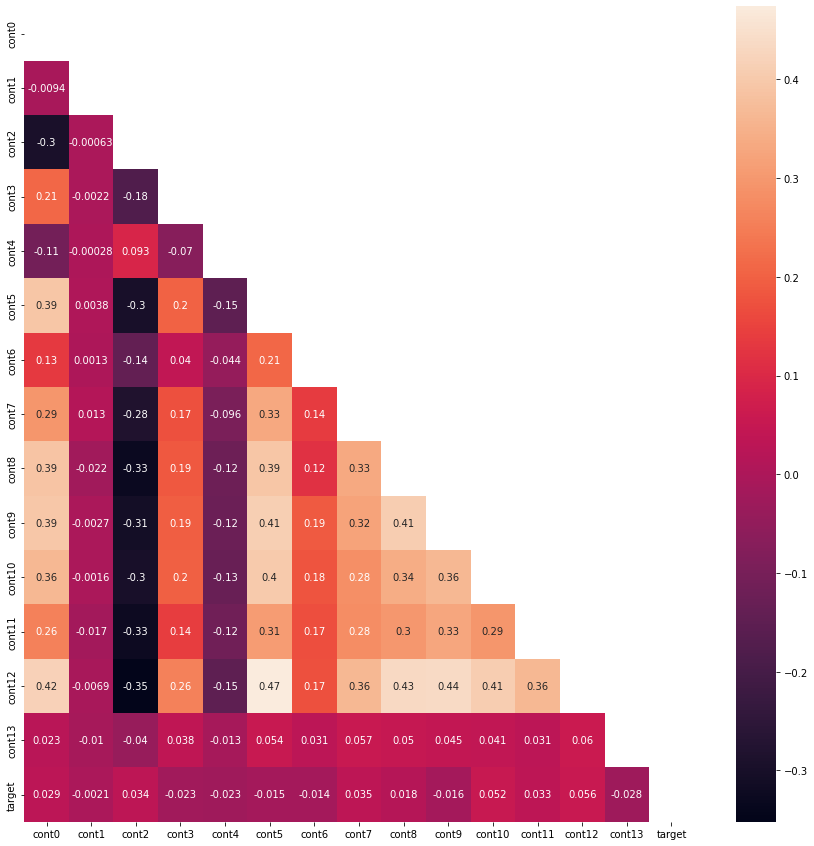

In [88]:
plt.figure(figsize=(15,15))
mask = np.triu(np.ones(df.corr().shape))
sns.heatmap(df.corr(), annot=True, mask=mask)

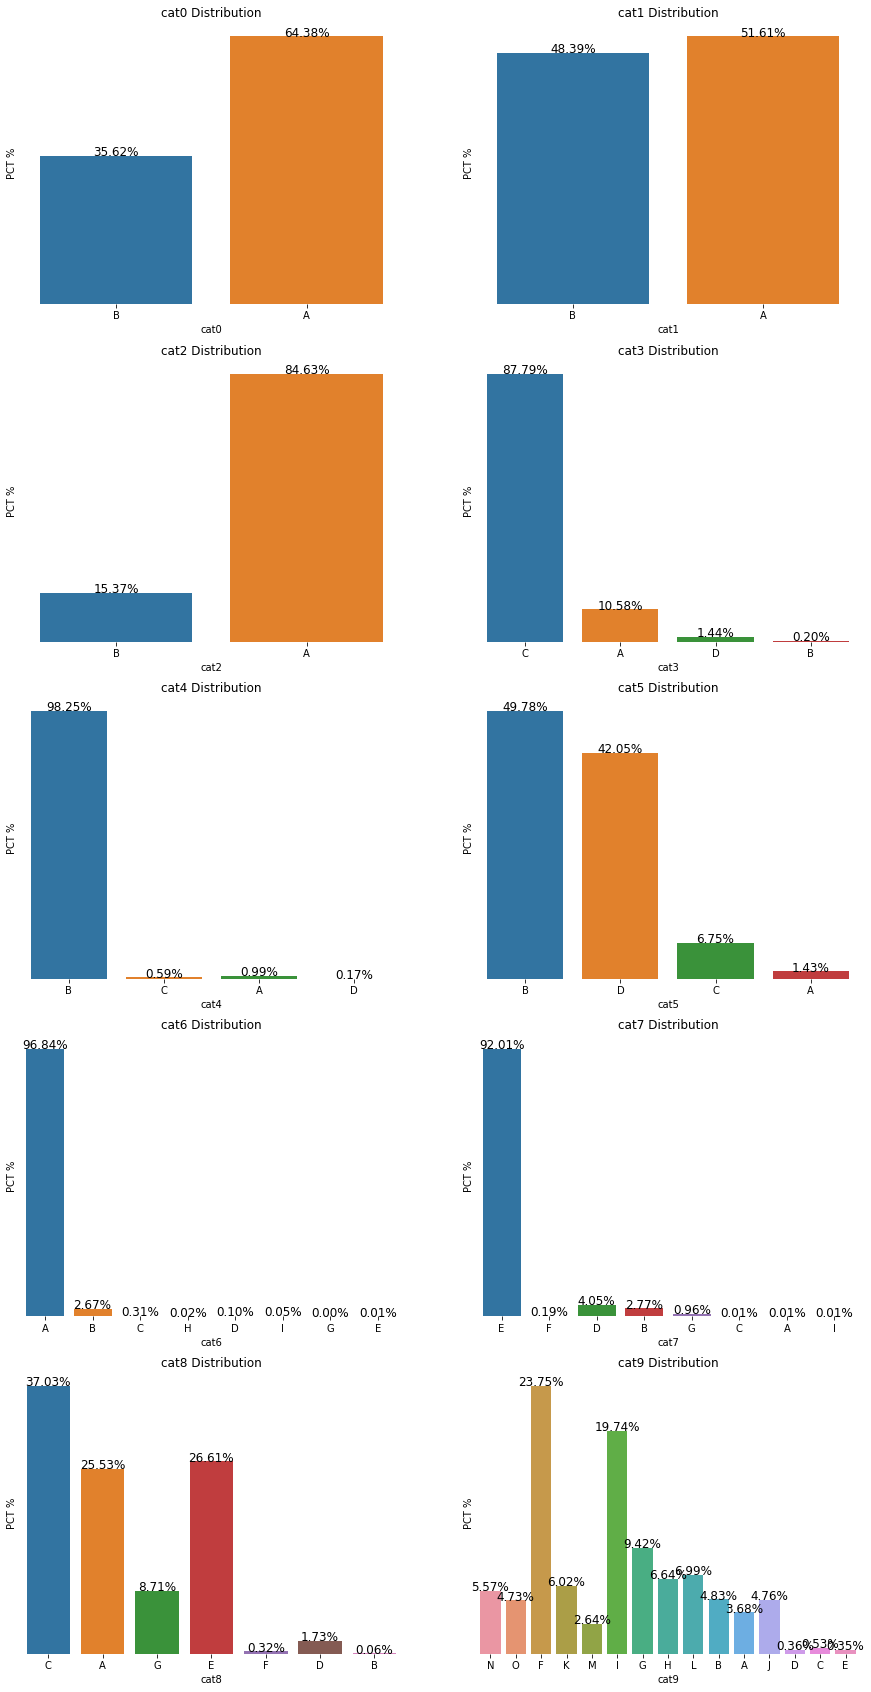

In [89]:
def count_plots_cat(df, num_rows=ceil(len(cat_cnames)/2),num_cols =2 , col_names=cat_cnames):

    fix, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15,30))
    axes = axes.ravel()
    for i in range(len(col_names)):
        col = col_names[i]
        sns.countplot(df[col], ax=axes[i]);
        axes[i].set_title(f"{col} Distribution");
        axes[i].set_yticklabels([]) # removing labels
        axes[i].set_yticks([]) # removign ticks
        axes[i].set_ylabel("PCT %")
        # removing borders 
        axes[i].spines['top'].set_visible(False)
        axes[i].spines['right'].set_visible(False)
        axes[i].spines['bottom'].set_visible(False)
        axes[i].spines['left'].set_visible(False)
        # showing values in plot
        for patch in axes[i].patches:
            # get the height of the patch
            h = patch.get_height()
            axes[i].text(patch.get_x()+patch.get_width()/2,
                        h+8,'{:.2f}%'.format(h*100/len(df)),
                    fontsize = 12,ha = 'center')


count_plots_cat(df)

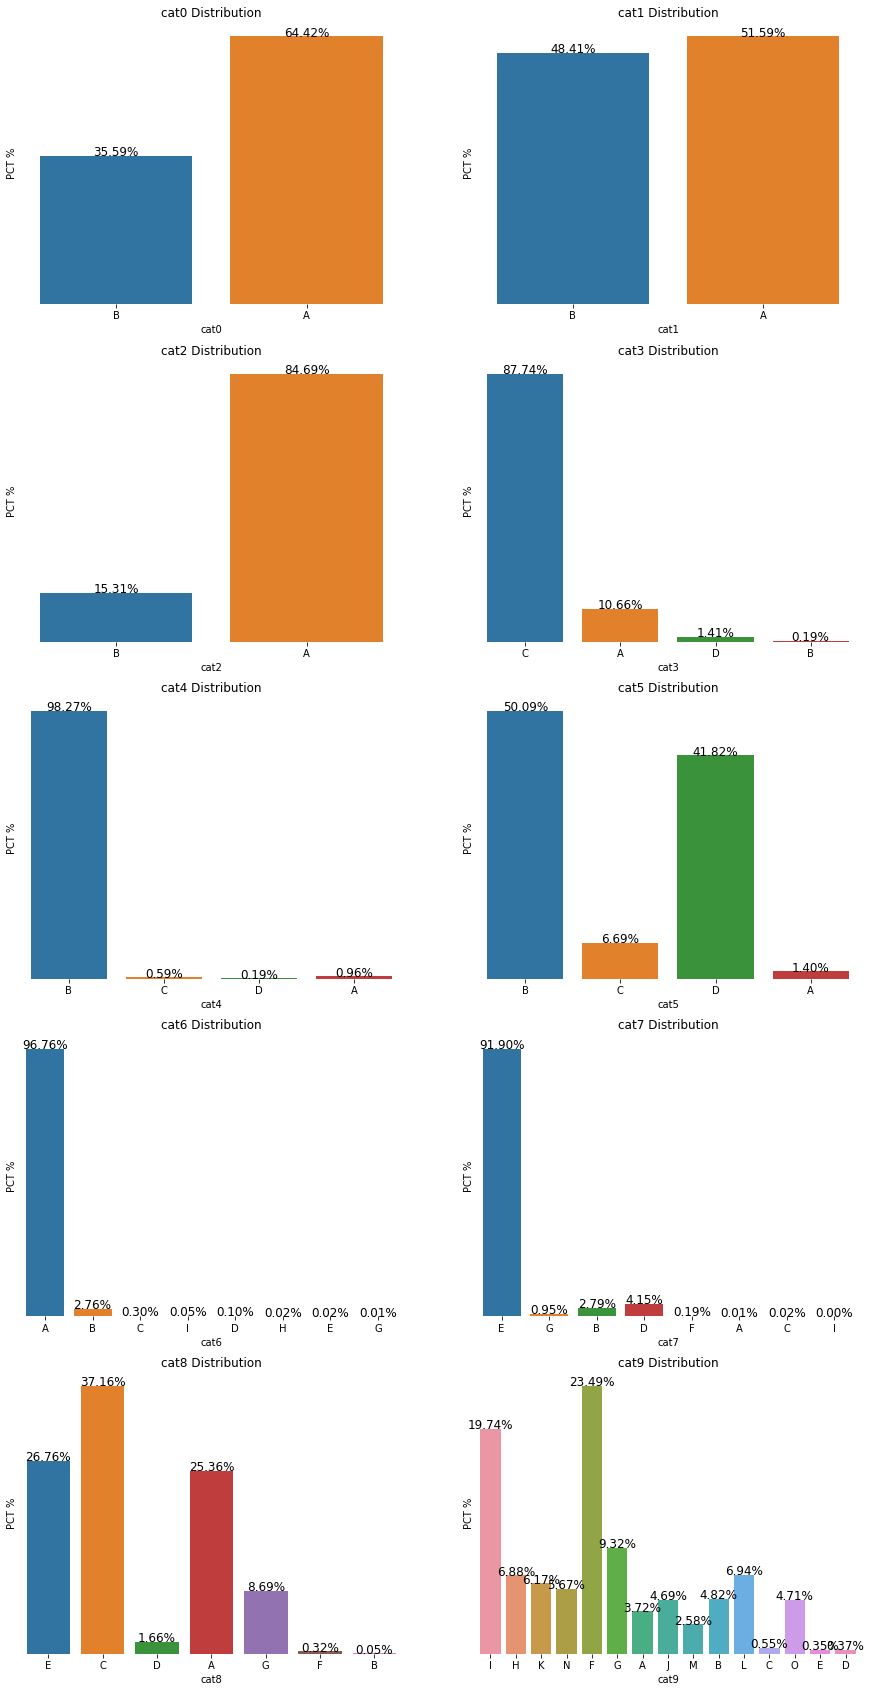

In [90]:
# for test data
count_plots_cat(X_test)

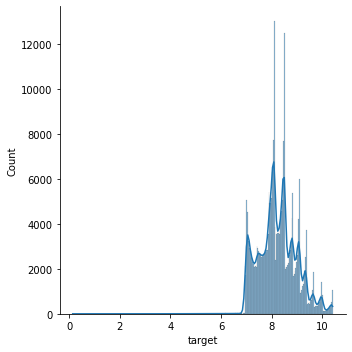

In [91]:
# target distripution
#plt.figure(figsize=(20, 20))
sns.displot(df['target'], kde=True)

In [92]:
# there are some values less than 6.5 with low frequencey
# given the distribution above, the values below 6 are considered to be low frequency. 
THRESHOLD = 6.5
df = df[df['target'] >=THRESHOLD]
df.shape

(299468, 25)

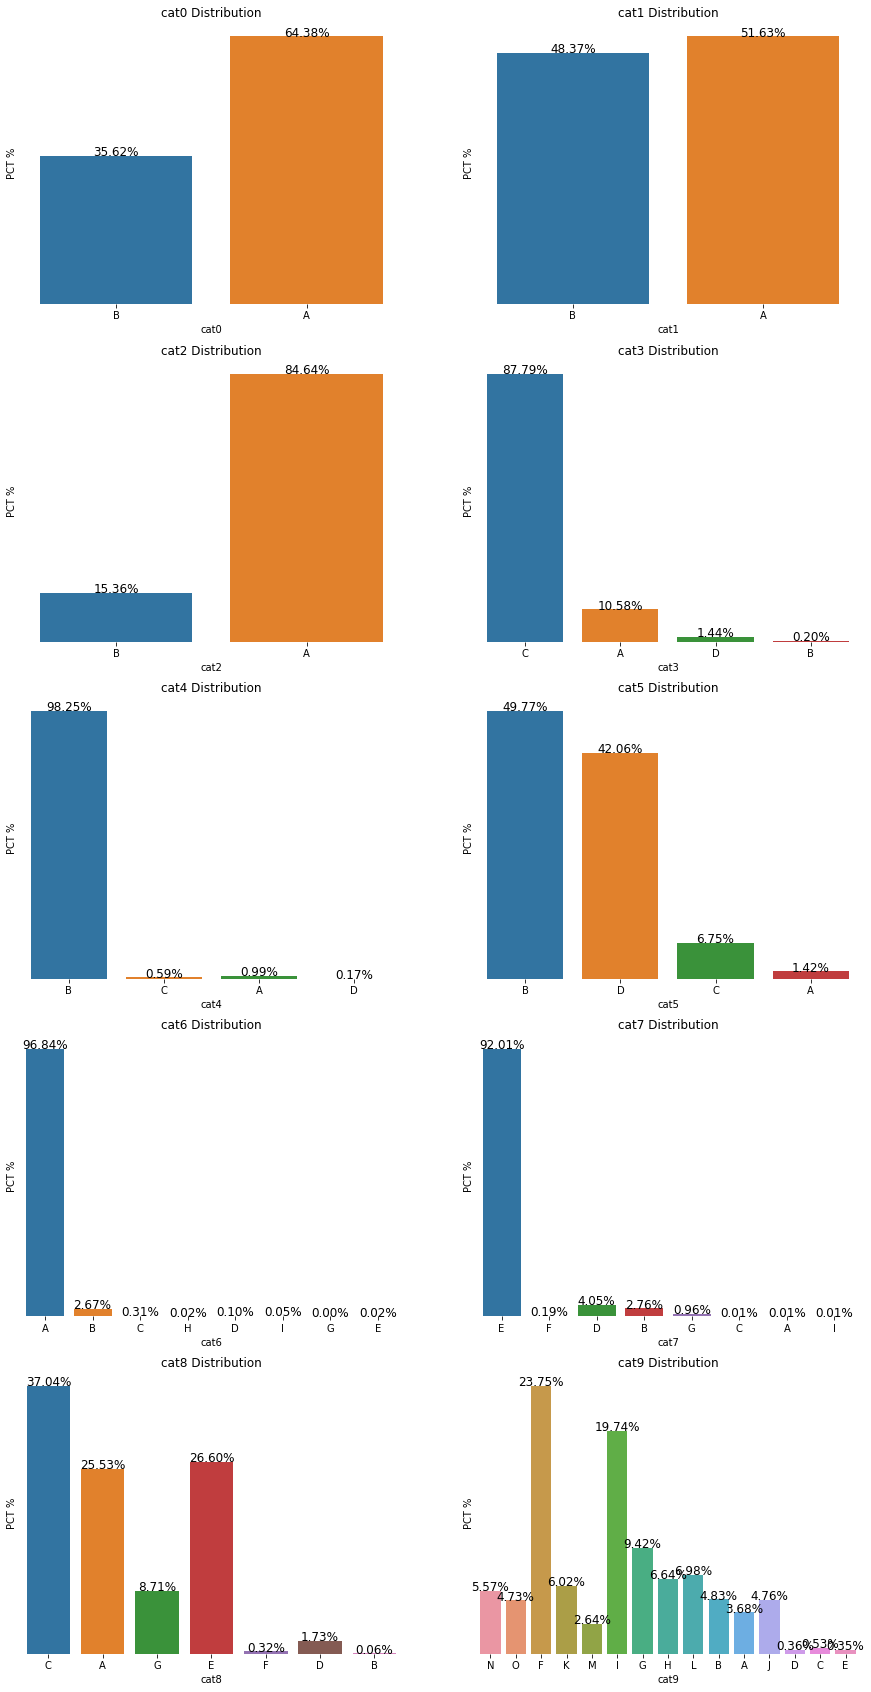

In [93]:
count_plots_cat(df)

In [94]:
trial = df.cat6.value_counts(normalize=True).to_dict()
max(trial, key=trial.get)


'A'

In [95]:
# encoded df
encoded_df = df.copy()

In [114]:
encoded_df.shape

(299468, 25)

In [96]:
def my_encoder(df, cname):
    value_counts = df[cname].value_counts(normalize=True).to_dict()
    dominant_value = max(value_counts, key=value_counts.get)
    df[f"{cname}_isDominant"] = df[cname].apply(lambda x: 1 if x==dominant_value else 0)
    df.drop(cname, axis=1, inplace=True)
    return df

# category columns with 1 value of more than 90% of data 
one_value_cat = []
for cname in cat_cnames:
    if df[cname].value_counts().iloc[0]/len(df) > 0.9:
        one_value_cat.append(cname)

one_value_cat



['cat4', 'cat6', 'cat7']

In [97]:
for cname in one_value_cat:
    
    if cname in cat_cnames:
        my_encoder(encoded_df, cname)

In [98]:

# transforming X_test as well
for cname in one_value_cat:    
    if cname in cat_cnames:

        my_encoder(X_test, cname)


In [101]:
encoded_df

,cat0,cat1,cat2,cat3,cat5,cat8,cat9,cont0,cont1,cont2,...,cont8,cont9,cont10,cont11,cont12,cont13,target,cat4_isDominant,cat6_isDominant,cat7_isDominant
id,,,,,,,,,,,,,,,,,,,,,
1,B,B,B,C,B,C,N,0.201470,-0.014822,0.669699,...,0.389470,0.267559,0.237281,0.377873,0.322401,0.869850,8.113634,1,1,1
2,B,B,A,A,D,A,O,0.743068,0.367411,1.021605,...,0.594928,0.341439,0.906013,0.921701,0.261975,0.465083,8.481233,1,1,0
3,A,A,A,C,D,A,F,0.742708,0.310383,-0.012673,...,0.555205,0.843531,0.748809,0.620126,0.541474,0.763846,8.364351,1,1,0
4,B,B,A,C,D,C,K,0.429551,0.620998,0.577942,...,0.679618,0.574844,0.346010,0.714610,0.540150,0.280682,8.049253,1,1,1
6,A,A,A,C,D,A,N,1.058291,0.367492,-0.052389,...,0.684501,0.956692,1.000773,0.776742,0.625849,0.250823,7.972260,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499993,B,B,A,A,D,A,I,0.697124,0.483452,0.297770,...,1.005077,0.853726,0.422541,1.063463,0.697685,0.506404,7.945605,1,1,1
499996,A,B,A,C,B,E,F,0.446200,0.715135,0.610931,...,0.257825,0.433525,0.301015,0.268447,0.577055,0.823611,7.326118,1,1,1
499997,B,B,A,C,C,G,F,0.544279,0.060937,0.590955,...,0.383224,0.551825,0.661007,0.629606,0.714139,0.245732,8.706755,1,1,1


In [78]:
X_test

,cat0,cat1,cat2,cat3,cat5,cat8,cat9,cont0,cont1,cont2,...,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cat4_isDominant,cat6_isDominant,cat7_isDominant
id,,,,,,,,,,,,,,,,,,,,,
0,B,B,B,C,B,E,I,0.296227,0.686757,0.587731,...,0.321832,0.445212,0.290258,0.244476,0.087914,0.301831,0.845702,1,1,1
5,A,B,A,C,C,C,H,0.543707,0.364761,0.452967,...,0.835961,0.391657,0.288276,0.549568,0.905097,0.850684,0.693940,1,1,1
15,B,A,A,A,B,D,K,0.408961,0.296129,0.690999,...,0.879379,0.275549,0.427871,0.491667,0.384315,0.376689,0.508099,1,1,1
16,B,B,A,C,D,A,N,1.031239,0.356062,0.303651,...,0.644315,1.024017,0.391090,0.988340,0.411828,0.393585,0.461372,1,1,1
17,B,B,A,C,C,C,F,0.530447,0.729004,0.281723,...,0.408874,0.447887,0.390253,0.648932,0.385935,0.370401,0.900412,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499987,B,A,A,C,D,E,I,0.505445,0.710839,0.225285,...,1.028978,1.022741,0.683903,0.877273,0.532410,0.605397,0.884581,1,1,1
499990,B,A,A,C,B,C,F,0.350751,0.887132,0.346864,...,0.359871,0.550013,0.492082,0.202295,0.416875,0.406205,0.758665,1,1,1
499991,A,B,B,C,B,C,I,0.378393,0.549489,0.411319,...,0.317185,0.150340,0.122109,0.390524,0.334026,0.378987,0.839416,1,1,1


In [70]:
df

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target,cat4_isDominant
id,,,,,,,,,,,,,,,,,,,,,
1,B,B,B,C,B,B,A,E,C,N,...,0.160266,0.310921,0.389470,0.267559,0.237281,0.377873,0.322401,0.869850,8.113634,1
2,B,B,A,A,B,D,A,F,A,O,...,0.558922,0.516294,0.594928,0.341439,0.906013,0.921701,0.261975,0.465083,8.481233,1
3,A,A,A,C,B,D,A,D,A,F,...,0.375348,0.902567,0.555205,0.843531,0.748809,0.620126,0.541474,0.763846,8.364351,1
4,B,B,A,C,B,D,A,E,C,K,...,0.239061,0.732948,0.679618,0.574844,0.346010,0.714610,0.540150,0.280682,8.049253,1
6,A,A,A,C,B,D,A,E,A,N,...,0.420667,0.648182,0.684501,0.956692,1.000773,0.776742,0.625849,0.250823,7.972260,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499993,B,B,A,A,B,D,A,E,A,I,...,0.450538,0.934360,1.005077,0.853726,0.422541,1.063463,0.697685,0.506404,7.945605,1
499996,A,B,A,C,B,B,A,E,E,F,...,0.508502,0.358247,0.257825,0.433525,0.301015,0.268447,0.577055,0.823611,7.326118,1
499997,B,B,A,C,B,C,A,E,G,F,...,0.372425,0.364936,0.383224,0.551825,0.661007,0.629606,0.714139,0.245732,8.706755,1


In [102]:
y = df.target.copy()
X = df.drop('target', axis=1).copy()
X.shape

(299468, 24)

In [103]:

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1)


In [24]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(239574, 24)
(239574,)
(59894, 24)
(59894,)


In [25]:
# category columns with 1 value of more than 90% of data 
one_value_cat = []
for cname in cat_cnames:
    if df[cname].value_counts().iloc[0]/len(df) > 0.9:
        one_value_cat.append(cname)

one_value_cat

['cat4', 'cat6', 'cat7']

In [26]:
# dominant categories 
dominant_cat_dict = {}
for cname in one_value_cat:
    most_frequent_value = X[cname].value_counts().sort_values(ascending=False).index[0]
    dominant_cat_dict[cname] = most_frequent_value

dominant_cat_dict

{'cat4': 'B', 'cat6': 'A', 'cat7': 'E'}

In [104]:
# transformers
num_transformer = StandardScaler()
cat_transformer = OrdinalEncoder()

# preprocessing
preprocessor = ColumnTransformer(transformers=[
    ('cat', cat_transformer, cat_cnames)
], remainder='passthrough')


In [105]:
xgb_model = XGBRegressor(n_estimators=1350, max_depth=3
                         , learning_rate=0.01, objective='reg:squarederror', random_state=1)
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb_model)
])


In [106]:
xgb_pipeline.fit(X_train, y_train)


Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  OrdinalEncoder(categories='auto',
                                                                 dtype=<class 'numpy.float64'>),
                                                  ['cat0', 'cat1', 'cat2',
                                                   'cat3', 'cat4', 'cat5',
                                                   'cat6', 'cat7', 'cat8',
                                                   'cat9'])],
                                   verbose=False)),
                ('model',
                 XGBRegressor(base_score...
                              interaction_constraints='', learning_rate=0.01,
                             

In [107]:
prediction_v = xgb_pipeline.predict(X_valid)
rmse = mean_squared_error(y_valid, prediction_v)**(1/2)
print(f"RMSE after removing lower targets {rmse}")

RMSE after removing lower targets 0.7191790901241325


In [130]:
y_encoded = encoded_df.target.copy() 
X_encoded = encoded_df.drop('target', axis=1).copy()
X_train2, X_valid2, y_train2, y_valid2 = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=1)

In [138]:
X_valid2

,cat0,cat1,cat2,cat3,cat5,cat8,cat9,cont0,cont1,cont2,...,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cat4_isDominant,cat6_isDominant,cat7_isDominant
id,,,,,,,,,,,,,,,,,,,,,
493887,A,B,A,C,D,C,L,0.354246,0.247068,0.595628,...,0.219755,0.476761,0.869294,0.402189,0.166248,0.374684,0.864325,1,1,1
30838,A,B,A,C,B,C,N,0.542757,0.616966,0.576133,...,0.336911,0.734900,0.348055,0.213258,0.300451,0.592104,0.290530,1,1,1
123203,B,A,A,A,D,G,F,0.437120,0.628347,0.658281,...,0.878478,1.007631,0.670324,0.879108,0.779678,0.701920,0.304078,1,1,0
318457,A,A,A,C,D,A,I,0.401283,-0.060972,0.291244,...,1.024875,0.536262,0.431750,0.766261,0.575198,0.643306,0.460868,1,1,1
479317,B,B,A,C,C,C,F,0.668927,0.484963,0.614503,...,0.651867,0.609881,0.490552,0.855356,0.494761,0.816949,0.869714,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416983,B,A,B,C,D,A,J,0.855158,0.358934,0.693286,...,0.854927,1.013737,0.783135,0.697557,0.505441,0.815220,0.900085,1,1,0
155160,A,A,B,C,B,E,F,0.514783,0.628167,0.387463,...,0.236227,0.436916,0.600171,0.307148,0.532579,0.281566,0.333523,1,1,1
231073,A,B,A,C,B,C,M,0.394408,0.307160,0.466562,...,0.318108,0.319990,0.675515,0.113841,0.294471,0.403925,0.261788,1,1,1


In [131]:
encoded_cat_cnames = [cname for cname in encoded_df if encoded_df[cname].dtypes=='object']
encoded_cat_cnames

['cat0', 'cat1', 'cat2', 'cat3', 'cat5', 'cat8', 'cat9']

In [155]:
# transformers
num_transformer = StandardScaler()
cat_transformer = OrdinalEncoder()

# preprocessing
preprocessor = ColumnTransformer(transformers=[
    ('cat', cat_transformer, encoded_cat_cnames)
], remainder='passthrough')

xgb_model_encoded = XGBRegressor(n_estimators=1500, max_depth=6
                         , learning_rate=0.005, objective='reg:squarederror', random_state=1)
xgb_pipeline_encoded = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb_model_encoded)
])
xgb_pipeline_encoded.fit(X_train2, y_train2)


Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  OrdinalEncoder(categories='auto',
                                                                 dtype=<class 'numpy.float64'>),
                                                  ['cat0', 'cat1', 'cat2',
                                                   'cat3', 'cat5', 'cat8',
                                                   'cat9'])],
                                   verbose=False)),
                ('model',
                 XGBRegressor(base_score=0.5, booster='gbtree'...
                              interaction_constraints='', learning_rate=0.005,
                              max_delta_step=0, max_depth=6, min_child_weight=1,


In [144]:
def eval_model(model, X_v,y_v):
    predictions = model.predict(X_v)
    rmse = mean_squared_error(y_v, predictions)**(1/2)
    return rmse

In [156]:


rmse_encoded = eval_model(xgb_pipeline_encoded, X_valid2, y_valid2)
print(f"RMSE for replaced columns {rmse_encoded}")
predictions_encoded = xgb_pipeline_encoded.predict(X_test)
# RMSE for replaced columns 0.7191118376501257

RMSE for replaced columns 0.716404902762382


In [160]:

# full training set
xgb_pipeline_encoded.fit(X_encoded, y_encoded)
predictions_encoded = xgb_pipeline_encoded.predict(X_test)


In [157]:
predictions_encoded

array([8.031805, 8.27512 , 8.354975, ..., 8.342417, 8.105594, 8.155761],
      dtype=float32)

In [47]:
X_test = pd.read_csv(TEST_DATA_PATH, index_col='id')
predictions = xgb_pipeline.predict(X_test)

In [158]:
OUTPUT_PATH = 'output'
def output_submission(prediction, file_name):
    """creating a kaggle submission file

    Args:
        prediction (array): an array of predictions of the test dataset
        file_name (string): a string for the name without the extension
    """
    my_submission = pd.DataFrame({'target': prediction},
                                 index=X_test.index)
    #my_submission.set_index('id')
    file_path = os.path.join(OUTPUT_PATH,file_name)
    my_submission.to_csv(f'{file_path}.csv')
    print(f'A submission file has been made at {file_path}')

In [161]:
output_submission(predictions_encoded, "submission12")

A submission file has been made at output/submission12


In [52]:
X_valid.shape

(59894, 24)